In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from requests import head
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve, ConfusionMatrixDisplay
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
import tensorflow as tf

The dataset was found at : https://archive.ics.uci.edu/dataset/159/magic+gamma+telescope

in cell 3 we printed the dataset and found there were no labels so we added labels

In [3]:
cols = ["fLength", "fWidth",  "fSize",  "fConc",  "fConc1",  "fAsym",  "fM3Long",  "fM3Trans",  "fAlpha",  "fDist",  "class"]
df = pd.read_csv("magic04.data", names=cols)
df.head()

fLength    fWidth   fSize   fConc  fConc1     fAsym  fM3Long  fM3Trans  \
0   28.7967   16.0021  2.6449  0.3918  0.1982   27.7004  22.0110   -8.2027   
1   31.6036   11.7235  2.5185  0.5303  0.3773   26.2722  23.8238   -9.9574   
2  162.0520  136.0310  4.0612  0.0374  0.0187  116.7410 -64.8580  -45.2160   
3   23.8172    9.5728  2.3385  0.6147  0.3922   27.2107  -6.4633   -7.1513   
4   75.1362   30.9205  3.1611  0.3168  0.1832   -5.5277  28.5525   21.8393   

    fAlpha     fDist class  
0  40.0920   81.8828     g  
1   6.3609  205.2610     g  
2  76.9600  256.7880     g  
3  10.4490  116.7370     g  
4   4.6480  356.4620     g

we check the unique values class which happens to be g or h. for our computers understanding we use numbers(0,1) to represent g and h

In [4]:
df["class"] = (df["class"] == "g").astype(int)
#df["class"].unique()

In [5]:
df.head()

fLength    fWidth   fSize   fConc  fConc1     fAsym  fM3Long  fM3Trans  \
0   28.7967   16.0021  2.6449  0.3918  0.1982   27.7004  22.0110   -8.2027   
1   31.6036   11.7235  2.5185  0.5303  0.3773   26.2722  23.8238   -9.9574   
2  162.0520  136.0310  4.0612  0.0374  0.0187  116.7410 -64.8580  -45.2160   
3   23.8172    9.5728  2.3385  0.6147  0.3922   27.2107  -6.4633   -7.1513   
4   75.1362   30.9205  3.1611  0.3168  0.1832   -5.5277  28.5525   21.8393   

    fAlpha     fDist  class  
0  40.0920   81.8828      1  
1   6.3609  205.2610      1  
2  76.9600  256.7880      1  
3  10.4490  116.7370      1  
4   4.6480  356.4620      1

in the cell below we basically loop through diff columns and plot each column against corrresponding class column.

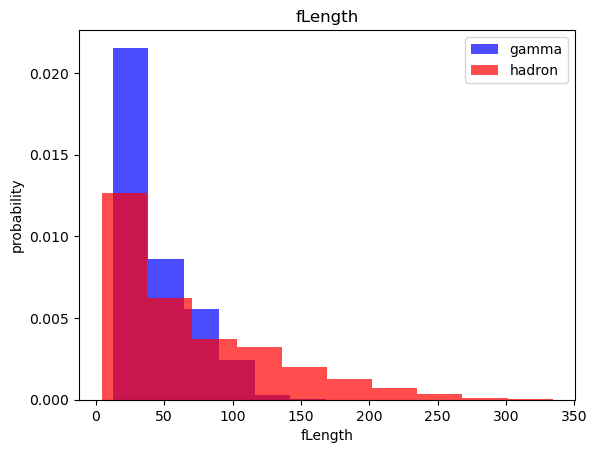

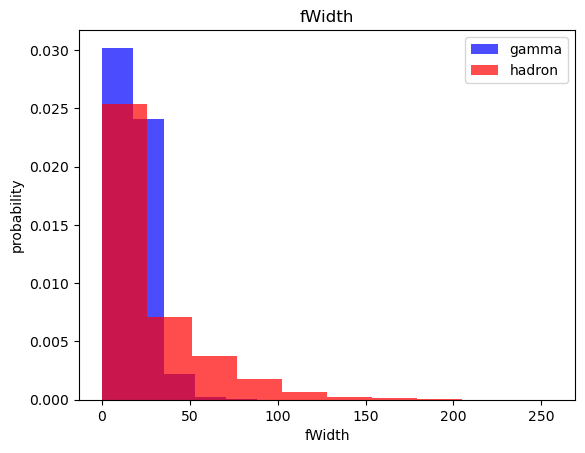

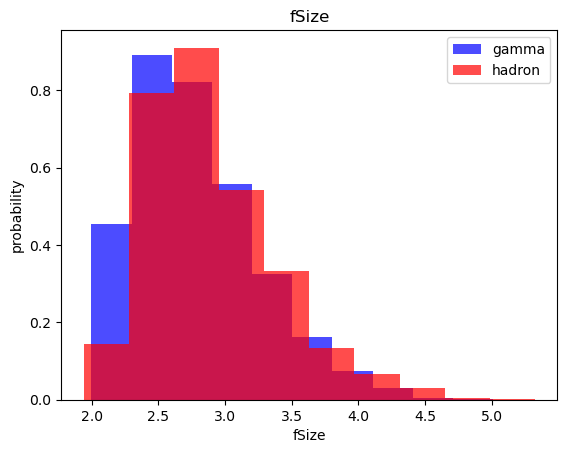

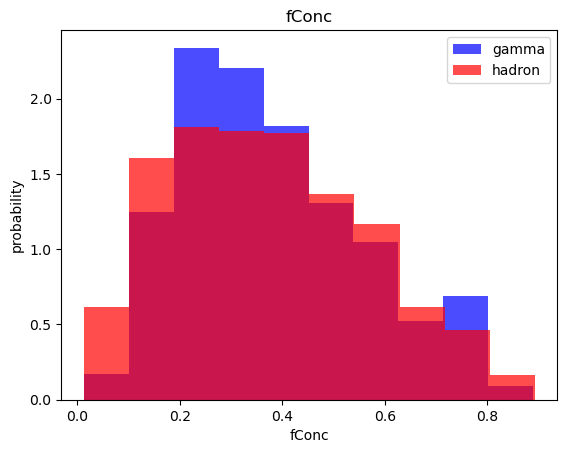

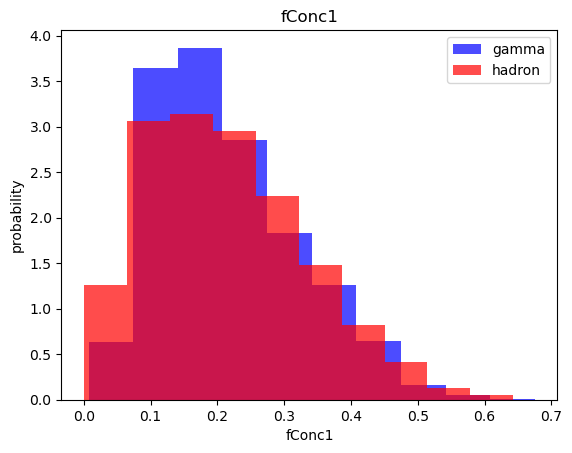

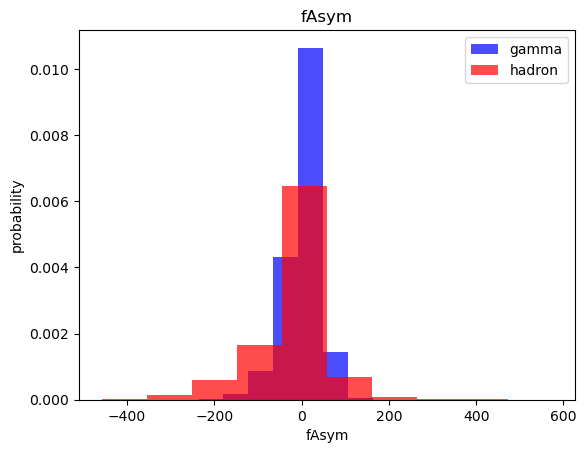

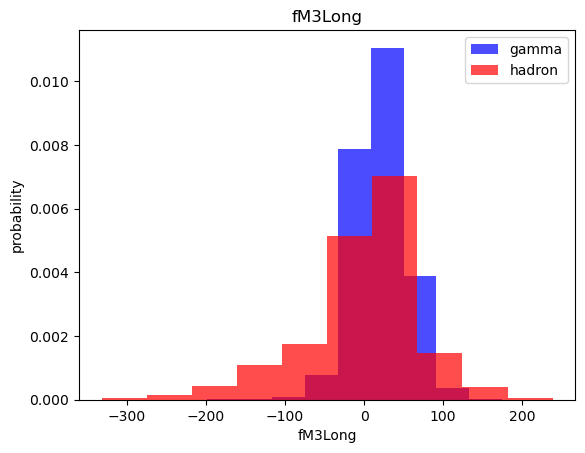

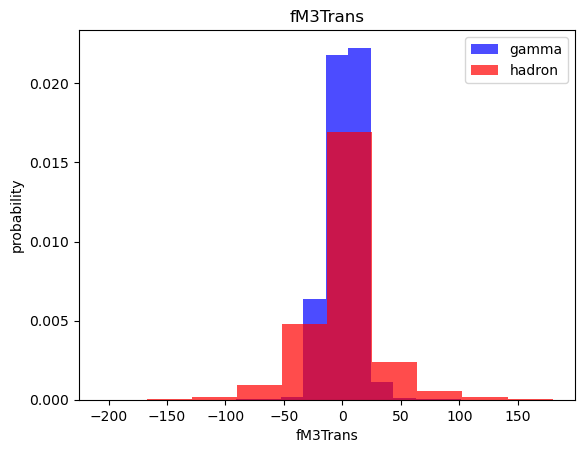

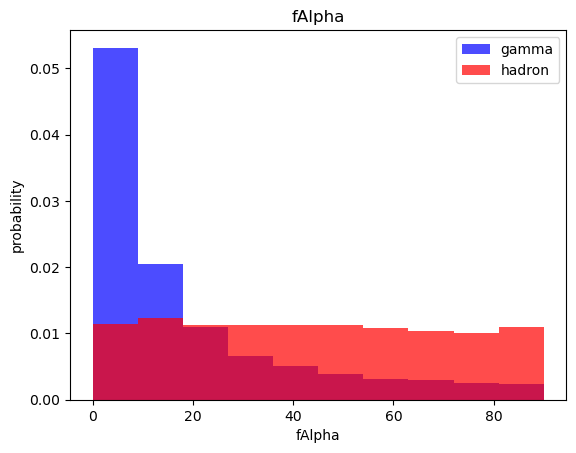

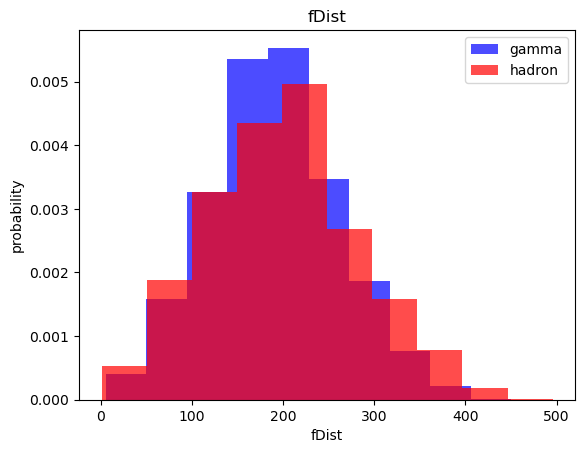

In [6]:
for label in cols[:-1]:
    plt.hist(df[df["class"] == 1][label],color='blue', label='gamma', alpha=0.7, density=True)
    plt.hist(df[df["class"] == 0][label],color='red', label='hadron', alpha=0.7, density=True)
    plt.title(label)
    plt.xlabel(label)
    plt.ylabel("probability")
    plt.legend()
    plt.show()

train, valid, and test data set

In [7]:
train, valid, test = np.split(df.sample(frac=1), [int(0.6*len(df)), int(0.8*len(df))])

/usr/lib/python3/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [8]:
def scale_dataset(dataframe, oversample=False):
    X = dataframe[dataframe.columns[:-1]].values
    y = dataframe[dataframe.columns[-1]].values

    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    if oversample:
        ros = RandomOverSampler()
        X, y = ros.fit_resample(X, y)

    data = np.hstack((X, np.reshape(y, (-1, 1))))

    return data, X, y

In [9]:
# i previously used created train variable using np.split now it is a dataframe using pd.DataFrame

train, X_train, y_train = scale_dataset(pd.DataFrame(train, columns=df.columns), oversample=True)
valid, X_valid, y_valid = scale_dataset(pd.DataFrame(valid, columns=df.columns), oversample=False)
test, X_test, y_test = scale_dataset(pd.DataFrame(test, columns=df.columns), oversample=False)


we checked if our data is evenly distributed for both gamma, hadron(0, 1)
"sum(y_train == 1), sum(y_train == 0)"

(7428, 7428)

# kNN


In [10]:
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train, y_train)

KNeighborsClassifier()

In [11]:
y_pred = knn_model.predict(X_test)

In [12]:
y_pred

array([1, 0, 1, ..., 1, 0, 1])

In [13]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.74      0.73      0.73      1310
           1       0.86      0.87      0.86      2494

    accuracy                           0.82      3804
   macro avg       0.80      0.80      0.80      3804
weighted avg       0.82      0.82      0.82      3804



Confusion matrix and Cross validation

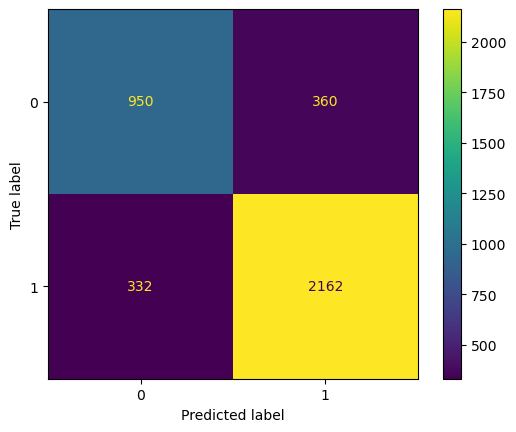

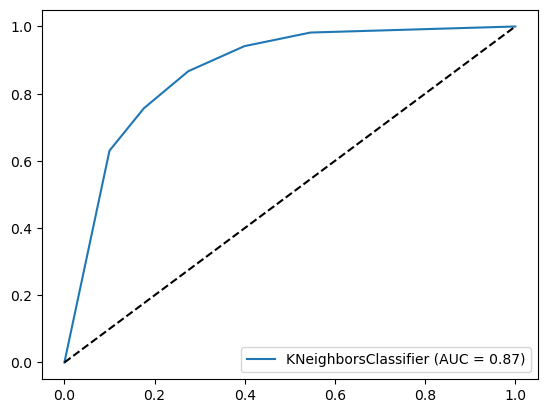

CV Accuracy: 0.838222923238696
CV Accuracy: 0.838222923238696


In [17]:
# Example for Confusion Matrix
y_pred = knn_model.predict(X_test)
ConfusionMatrixDisplay.from_estimator(knn_model, X_test, y_test)
plt.show()

# ROC Curve & AUC
y_proba = knn_model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr, label=f'{knn_model.__class__.__name__} (AUC = {roc_auc_score(y_test, y_proba):.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.legend()
plt.show()

# Prepare full dataset for cross-validation
X = df[df.columns[:-1]].values
y = df["class"].values

scaler = StandardScaler()
X = scaler.fit_transform(X)

cv_scores = cross_val_score(knn_model, X, y, cv=5)
print("CV Accuracy:", cv_scores.mean())

# Cross-validation
cv_scores = cross_val_score(knn_model, X, y, cv=5)
print("CV Accuracy:", cv_scores.mean())

# Naive Bayes 

In [14]:
nb_model = GaussianNB()
nb_model = nb_model.fit(X_train, y_train)
y_pred = nb_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.69      0.41      0.51      1355
           1       0.73      0.90      0.81      2449

    accuracy                           0.72      3804
   macro avg       0.71      0.65      0.66      3804
weighted avg       0.72      0.72      0.70      3804



# Logistic Regression

In [15]:
lg_model = LogisticRegression()
lg_model = lg_model.fit(X_train, y_train)
y_pred = lg_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.69      0.73      0.71      1355
           1       0.85      0.82      0.83      2449

    accuracy                           0.79      3804
   macro avg       0.77      0.77      0.77      3804
weighted avg       0.79      0.79      0.79      3804



SVM

In [16]:
svm_model = SVC()
svm_model = svm_model.fit(X_train, y_train)
y_pred = svm_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.78      0.81      1355
           1       0.88      0.91      0.90      2449

    accuracy                           0.87      3804
   macro avg       0.86      0.85      0.85      3804
weighted avg       0.87      0.87      0.87      3804



Neural net

In [17]:
def plot_history(history):
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
  ax1.plot(history.history['loss'], label='loss')
  ax1.plot(history.history['val_loss'], label='val_loss')
  ax1.set_xlabel('Epoch')
  ax1.set_ylabel('Binary crossentropy')
  ax1.grid(True)

  ax2.plot(history.history['accuracy'], label='accuracy')
  ax2.plot(history.history['val_accuracy'], label='val_accuracy')
  ax2.set_xlabel('Epoch')
  ax2.set_ylabel('Accuracy')
  ax2.grid(True)

  plt.show()

In [18]:
def train_model(X_train, y_train, num_nodes, dropout_prob, lr, batch_size, epochs):
  nn_model = tf.keras.Sequential([
      tf.keras.layers.Dense(num_nodes, activation='relu', input_shape=(10,)),
      tf.keras.layers.Dropout(dropout_prob),
      tf.keras.layers.Dense(num_nodes, activation='relu'),
      tf.keras.layers.Dropout(dropout_prob),
      tf.keras.layers.Dense(1, activation='sigmoid')
  ])

  nn_model.compile(optimizer=tf.keras.optimizers.Adam(lr), loss='binary_crossentropy',
                  metrics=['accuracy'])
  history = nn_model.fit(
    X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, verbose=0
  )

  return nn_model, history

16 nodes, dropout 0, lr 0.01, batch size 32


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-07-24 16:08:28.986972: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


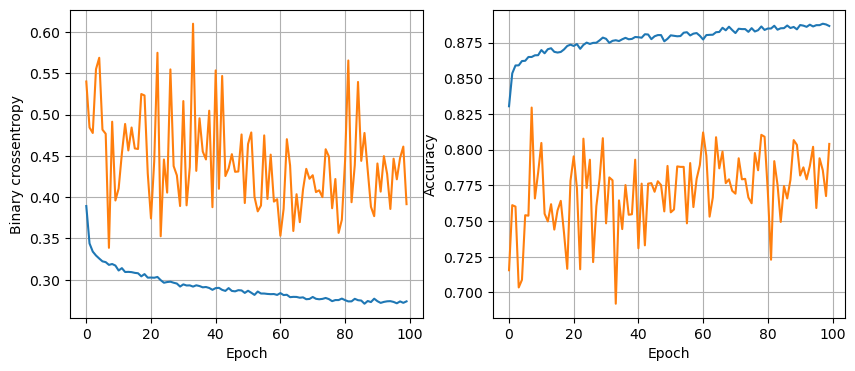

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step - accuracy: 0.8680 - loss: 0.3129
16 nodes, dropout 0, lr 0.01, batch size 64


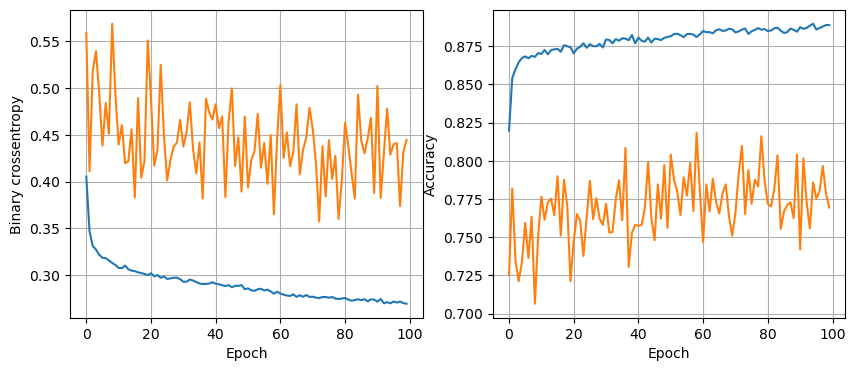

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step - accuracy: 0.8761 - loss: 0.3126
16 nodes, dropout 0, lr 0.01, batch size 128


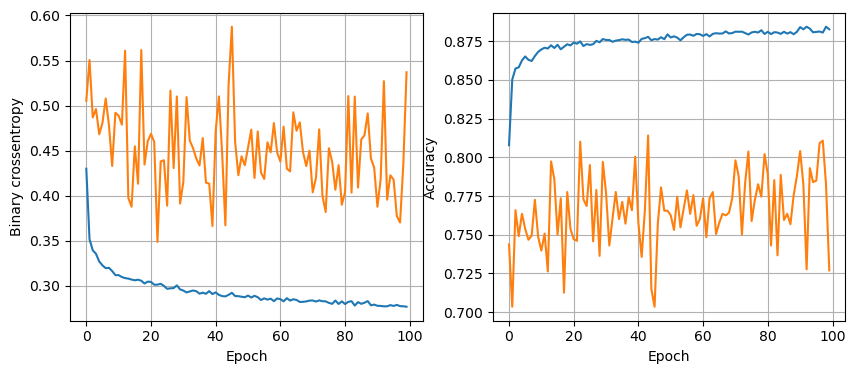

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8623 - loss: 0.3209  
16 nodes, dropout 0, lr 0.005, batch size 32


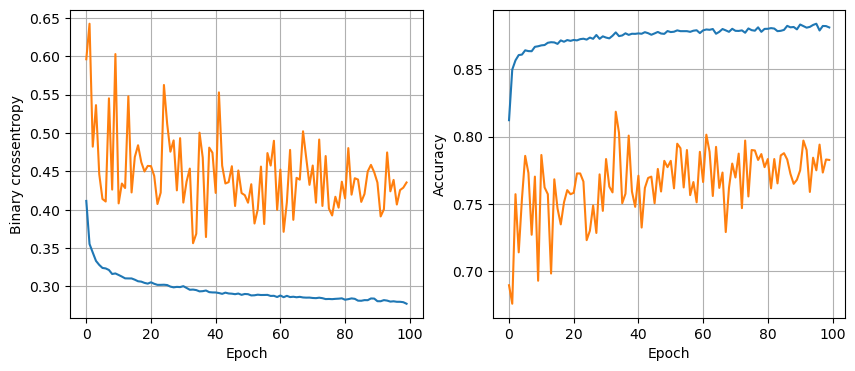

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step - accuracy: 0.8723 - loss: 0.3188
16 nodes, dropout 0, lr 0.005, batch size 64


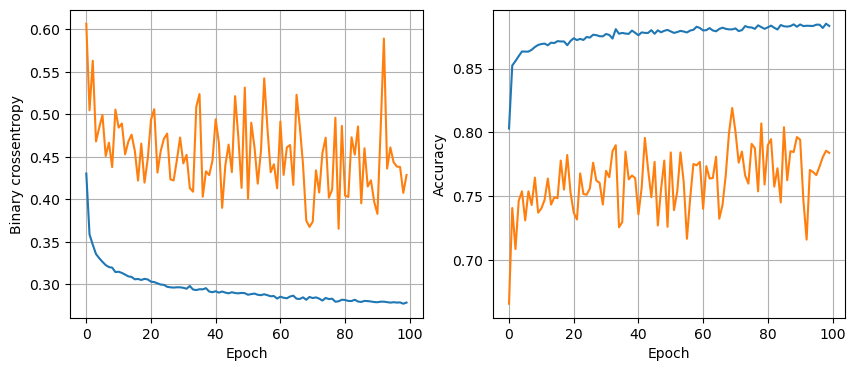

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step - accuracy: 0.8668 - loss: 0.3126
16 nodes, dropout 0, lr 0.005, batch size 128


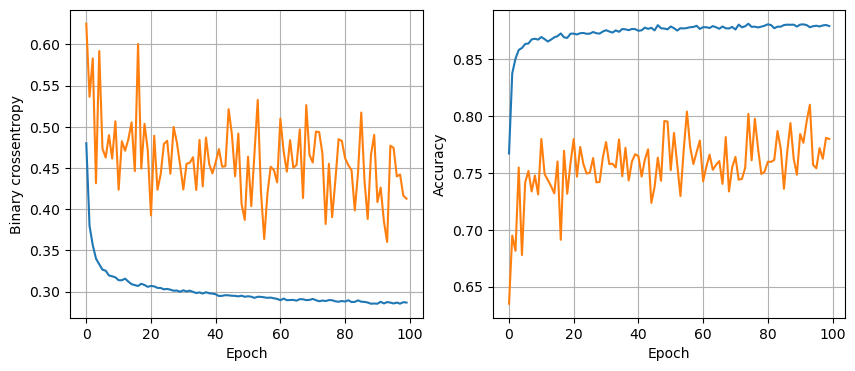

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8733 - loss: 0.3043  
16 nodes, dropout 0, lr 0.001, batch size 32


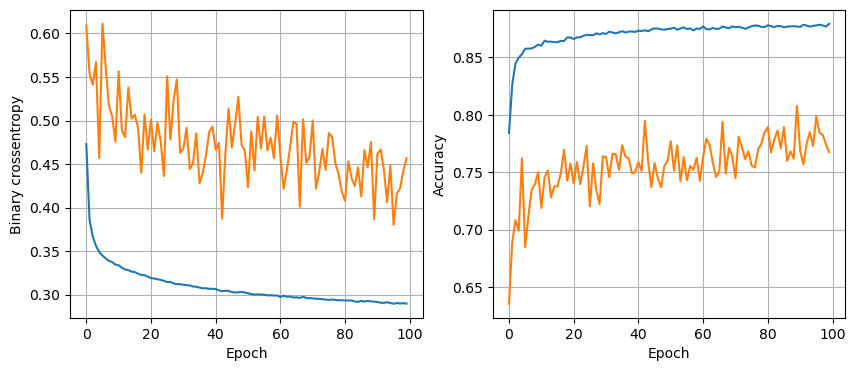

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8678 - loss: 0.3051  
16 nodes, dropout 0, lr 0.001, batch size 64


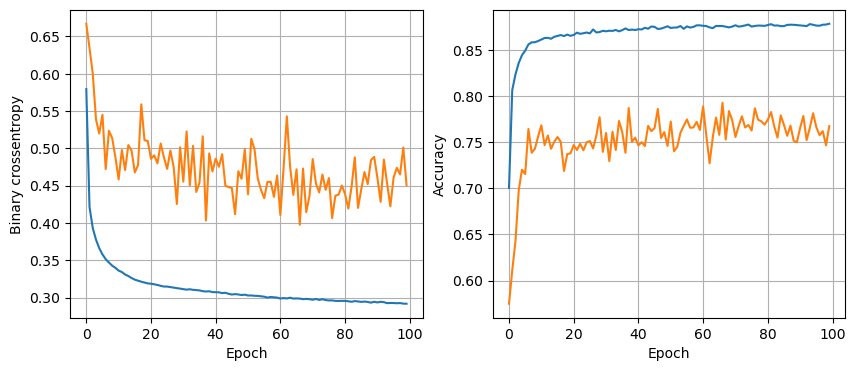

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step - accuracy: 0.8693 - loss: 0.3099
16 nodes, dropout 0, lr 0.001, batch size 128


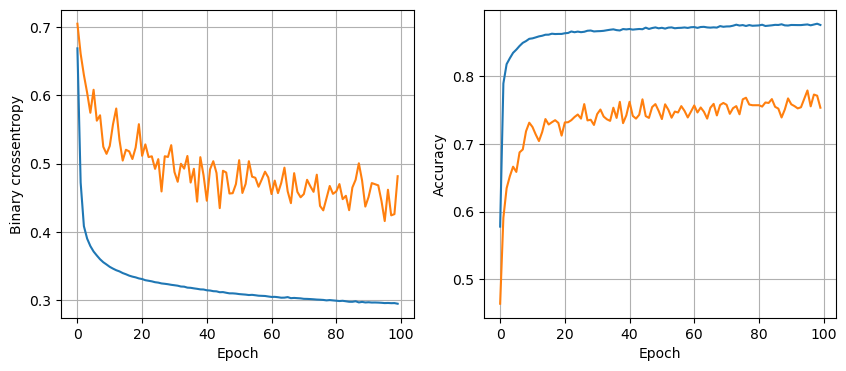

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8617 - loss: 0.3055  
16 nodes, dropout 0.2, lr 0.01, batch size 32


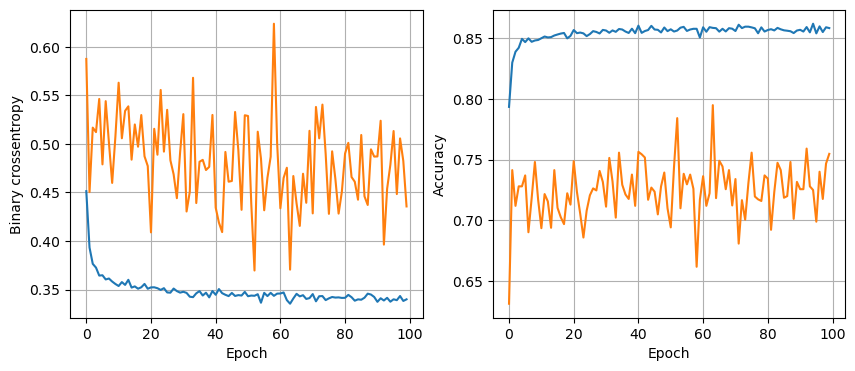

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8647 - loss: 0.3110  
16 nodes, dropout 0.2, lr 0.01, batch size 64


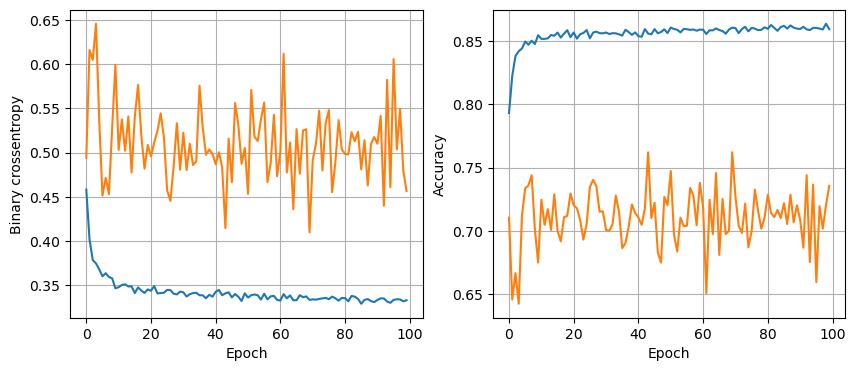

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step - accuracy: 0.8694 - loss: 0.3074
16 nodes, dropout 0.2, lr 0.01, batch size 128


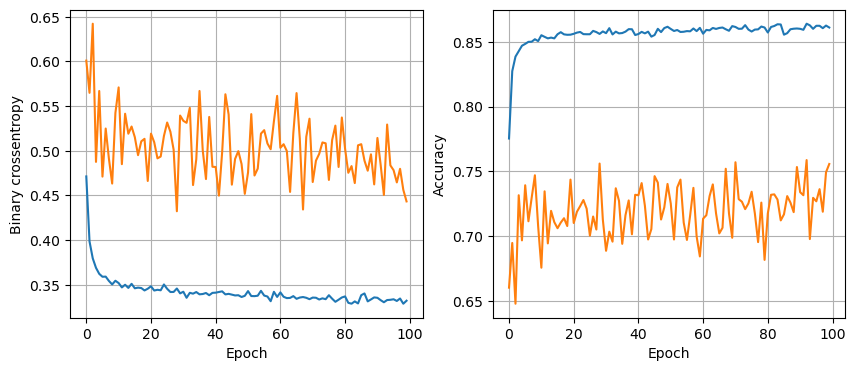

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8641 - loss: 0.3115  
16 nodes, dropout 0.2, lr 0.005, batch size 32


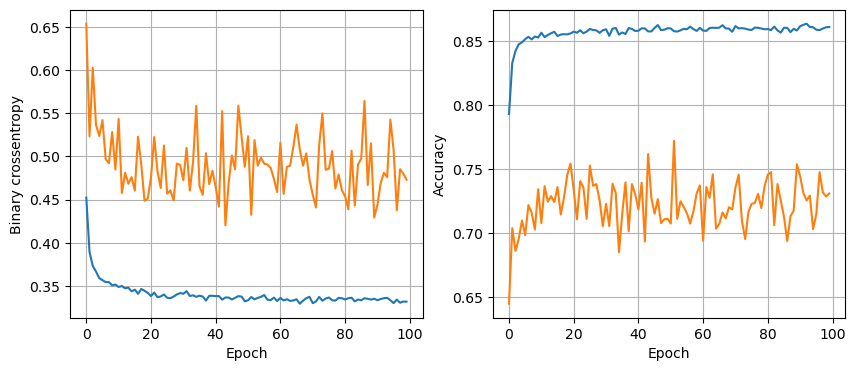

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8681 - loss: 0.3068  
16 nodes, dropout 0.2, lr 0.005, batch size 64


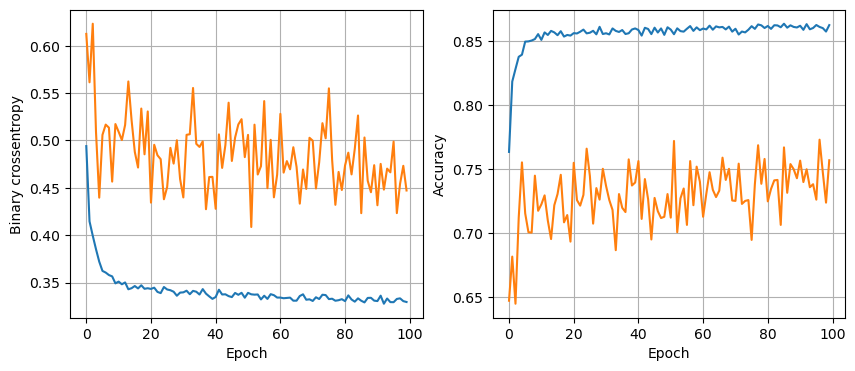

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step - accuracy: 0.8638 - loss: 0.3109
16 nodes, dropout 0.2, lr 0.005, batch size 128


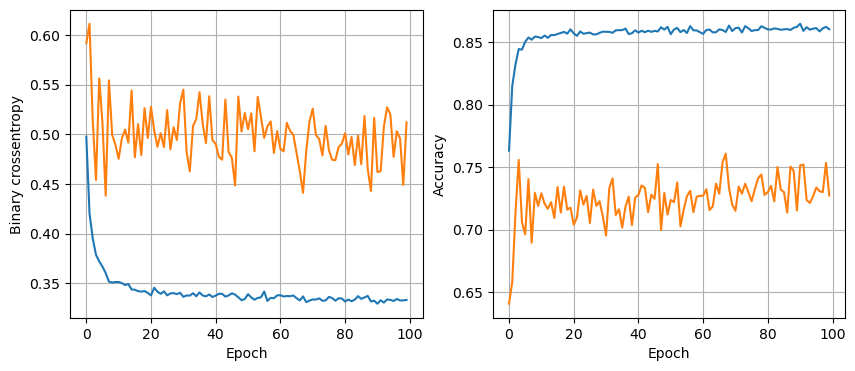

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 957us/step - accuracy: 0.8617 - loss: 0.3117
16 nodes, dropout 0.2, lr 0.001, batch size 32


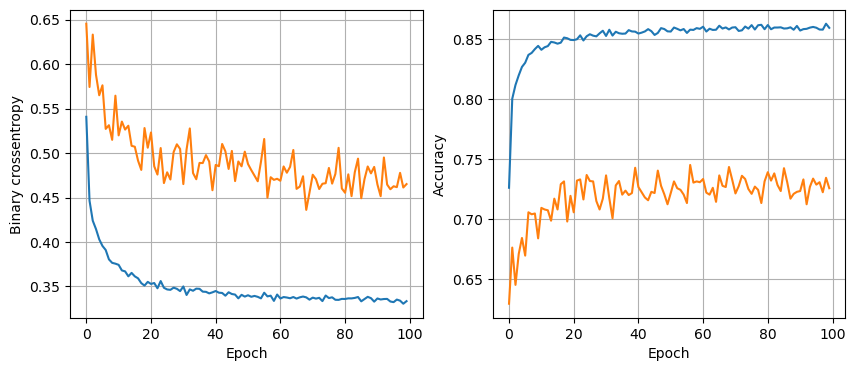

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8639 - loss: 0.3098  
16 nodes, dropout 0.2, lr 0.001, batch size 64


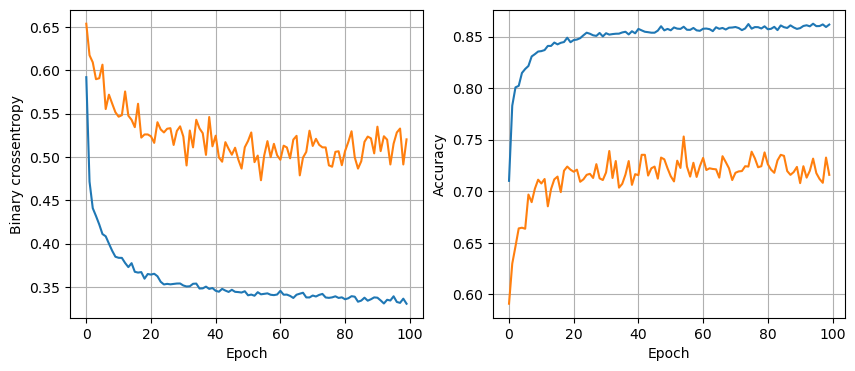

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8544 - loss: 0.3173  
16 nodes, dropout 0.2, lr 0.001, batch size 128


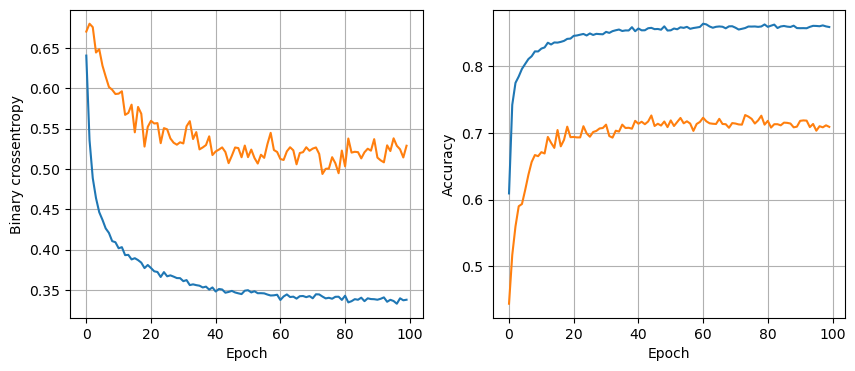

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8599 - loss: 0.3179
32 nodes, dropout 0, lr 0.01, batch size 32


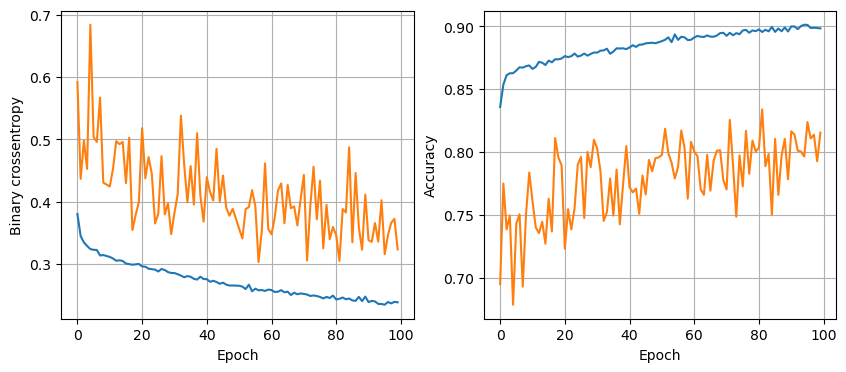

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8602 - loss: 0.3729
32 nodes, dropout 0, lr 0.01, batch size 64


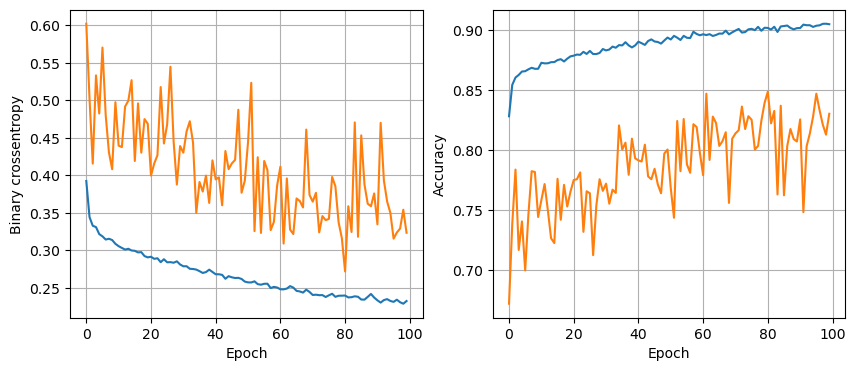

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8598 - loss: 0.3916
32 nodes, dropout 0, lr 0.01, batch size 128


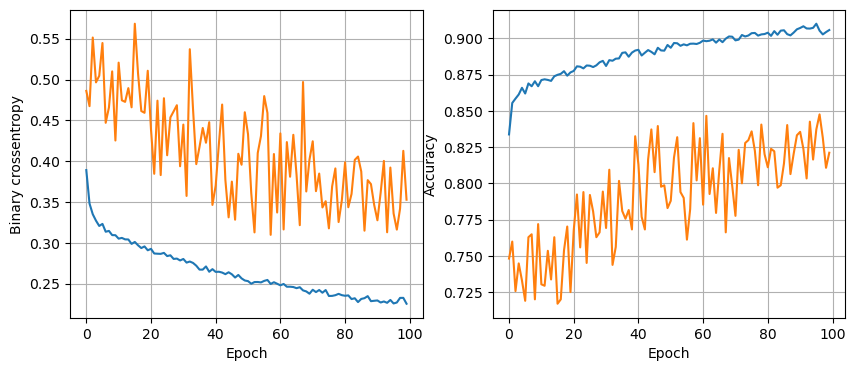

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8717 - loss: 0.3372
32 nodes, dropout 0, lr 0.005, batch size 32


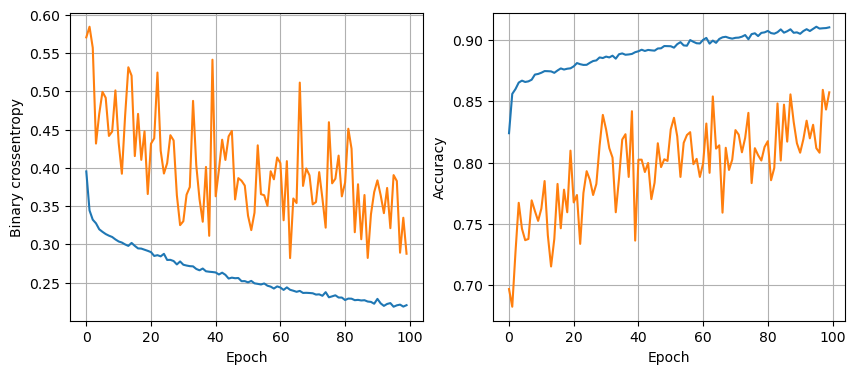

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8640 - loss: 0.3506
32 nodes, dropout 0, lr 0.005, batch size 64


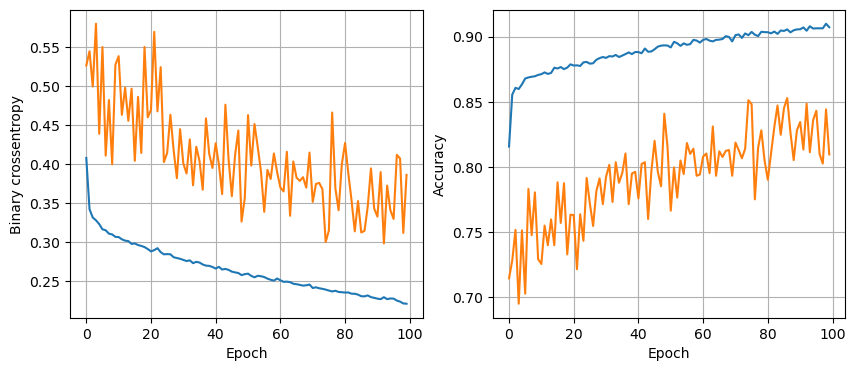

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8717 - loss: 0.3410
32 nodes, dropout 0, lr 0.005, batch size 128


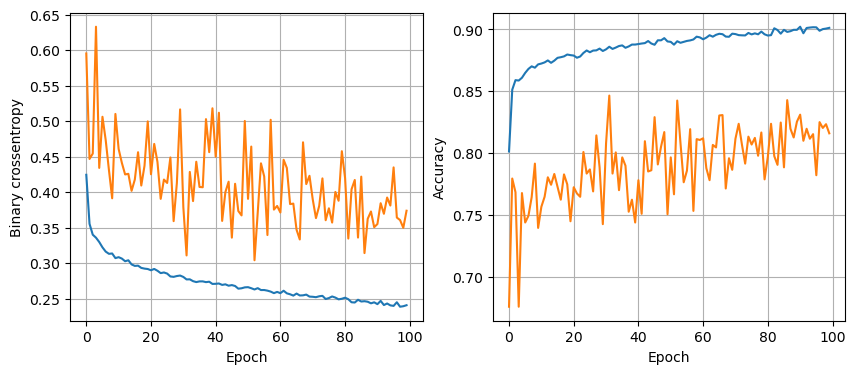

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8644 - loss: 0.3262
32 nodes, dropout 0, lr 0.001, batch size 32


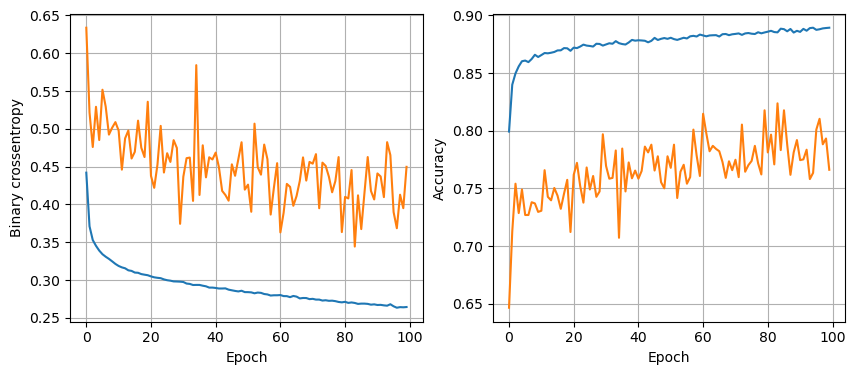

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8767 - loss: 0.3056
32 nodes, dropout 0, lr 0.001, batch size 64


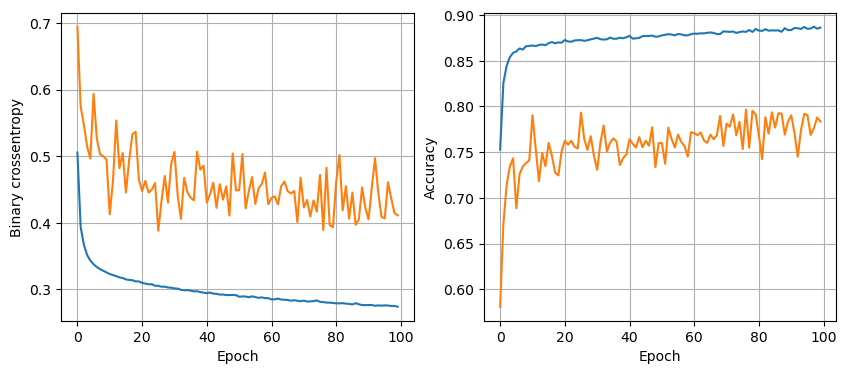

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8695 - loss: 0.3129  
32 nodes, dropout 0, lr 0.001, batch size 128


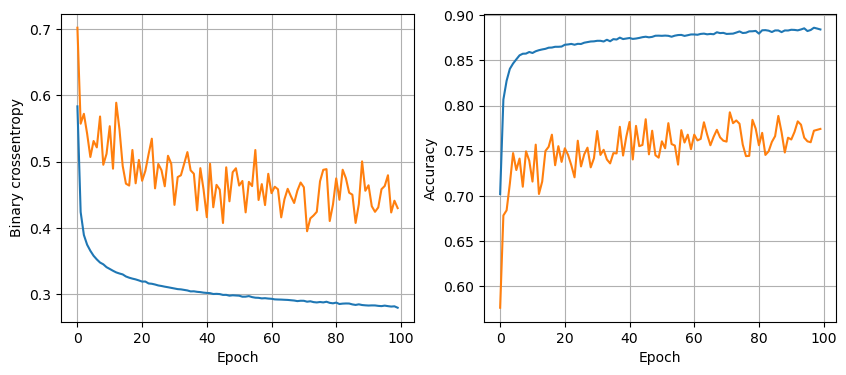

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8627 - loss: 0.2995  
32 nodes, dropout 0.2, lr 0.01, batch size 32


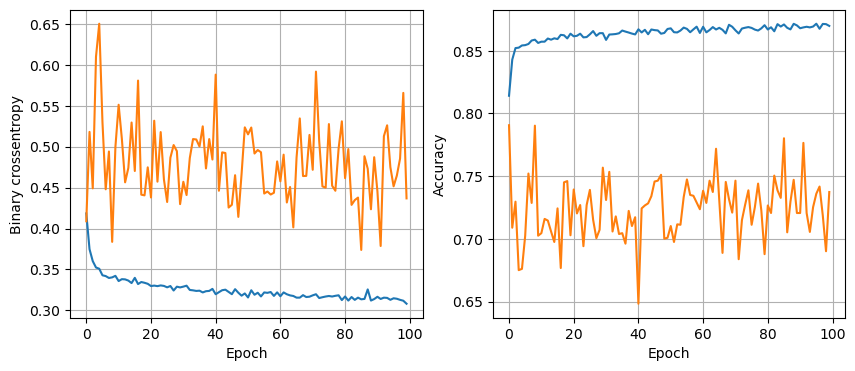

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8625 - loss: 0.3134  
32 nodes, dropout 0.2, lr 0.01, batch size 64


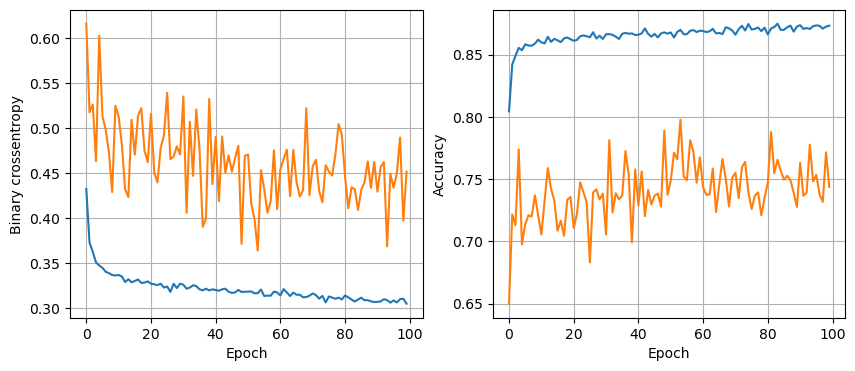

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8683 - loss: 0.3028  
32 nodes, dropout 0.2, lr 0.01, batch size 128


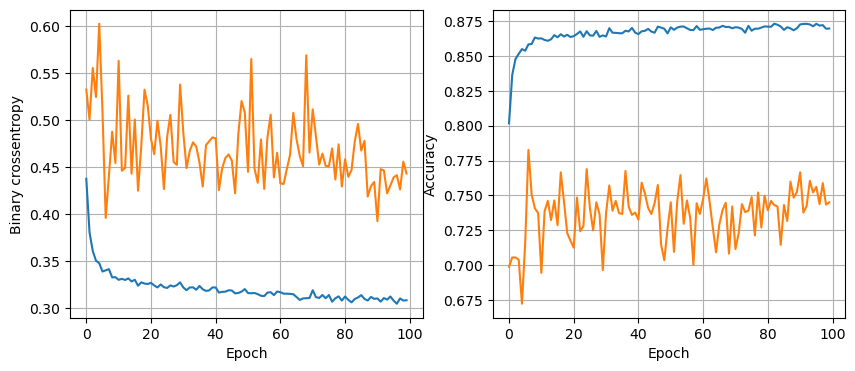

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8682 - loss: 0.3013  
32 nodes, dropout 0.2, lr 0.005, batch size 32


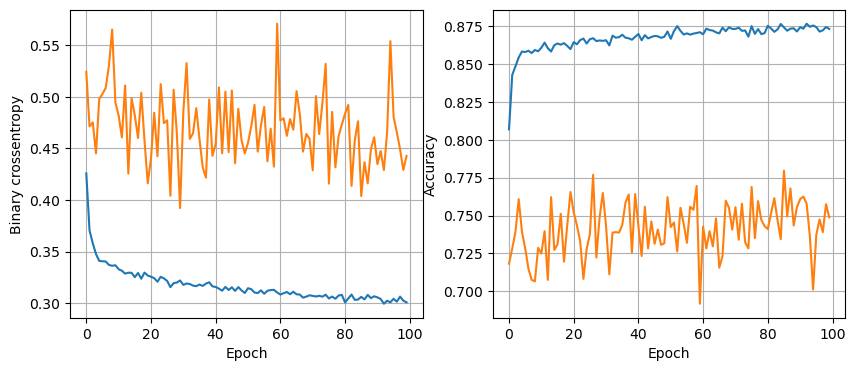

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8627 - loss: 0.3032  
32 nodes, dropout 0.2, lr 0.005, batch size 64


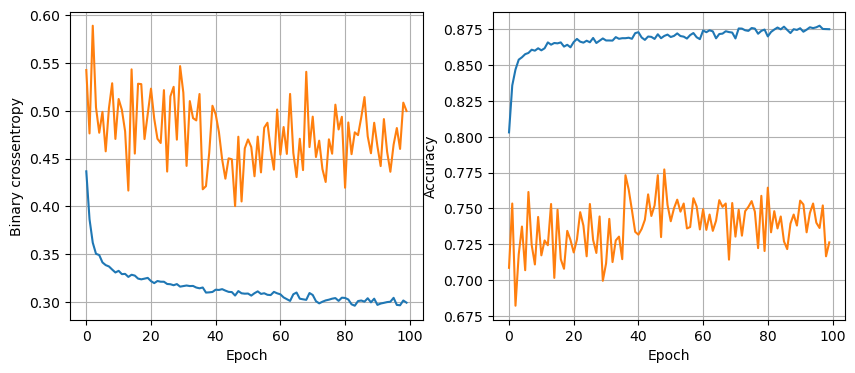

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8695 - loss: 0.3035  
32 nodes, dropout 0.2, lr 0.005, batch size 128


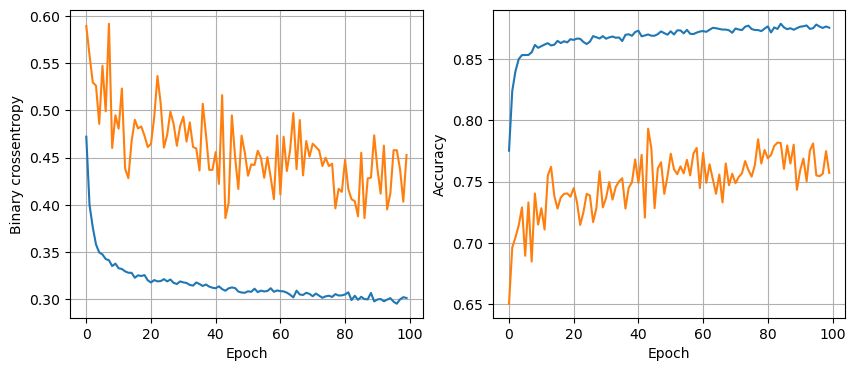

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8695 - loss: 0.2960  
32 nodes, dropout 0.2, lr 0.001, batch size 32


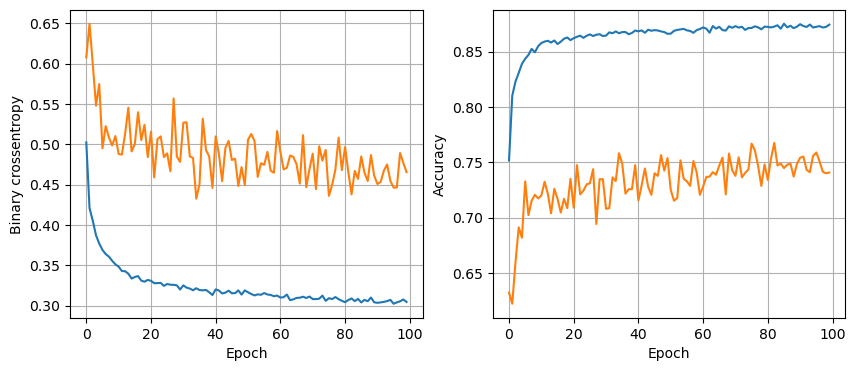

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8730 - loss: 0.2936  
32 nodes, dropout 0.2, lr 0.001, batch size 64


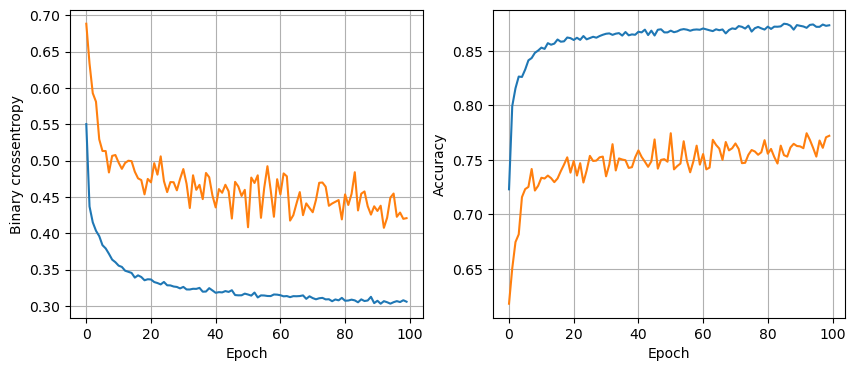

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8707 - loss: 0.2951  
32 nodes, dropout 0.2, lr 0.001, batch size 128


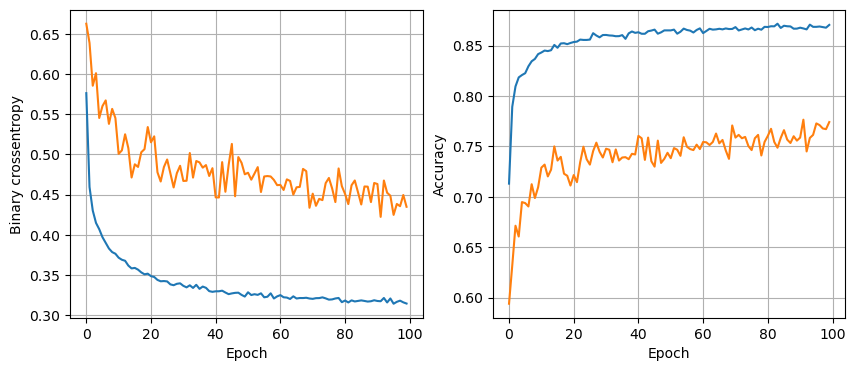

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8704 - loss: 0.2997  
64 nodes, dropout 0, lr 0.01, batch size 32


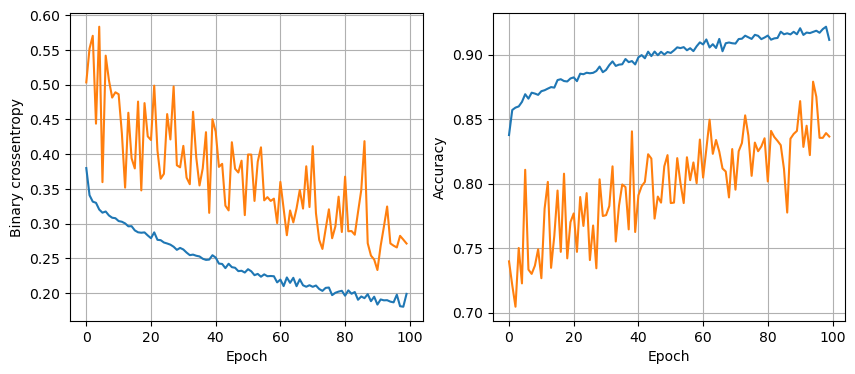

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8554 - loss: 0.5003  
64 nodes, dropout 0, lr 0.01, batch size 64


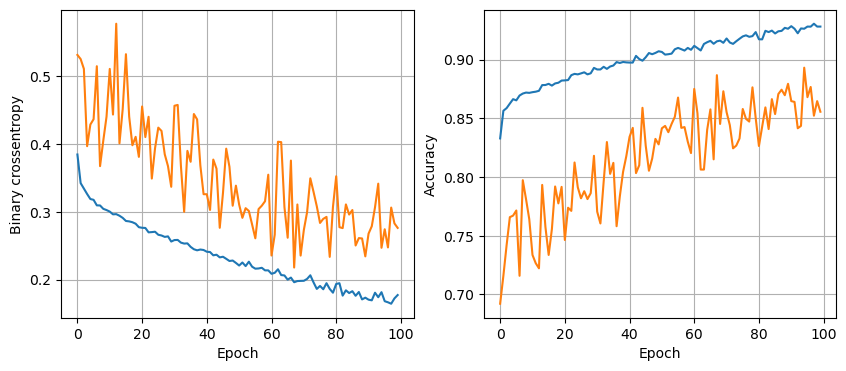

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8547 - loss: 0.5197  
64 nodes, dropout 0, lr 0.01, batch size 128


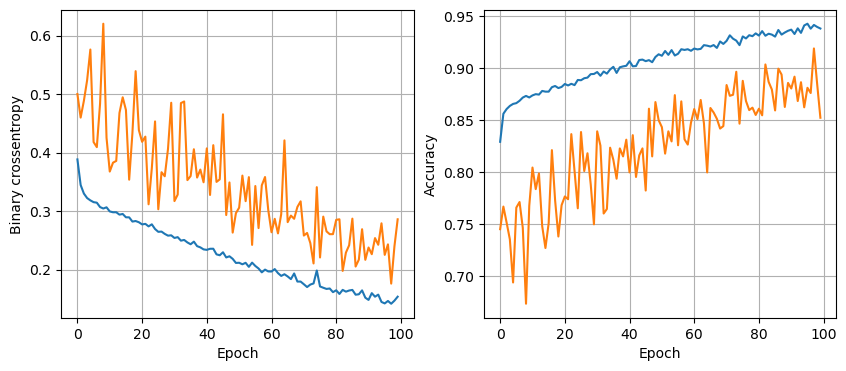

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8624 - loss: 0.5149
64 nodes, dropout 0, lr 0.005, batch size 32


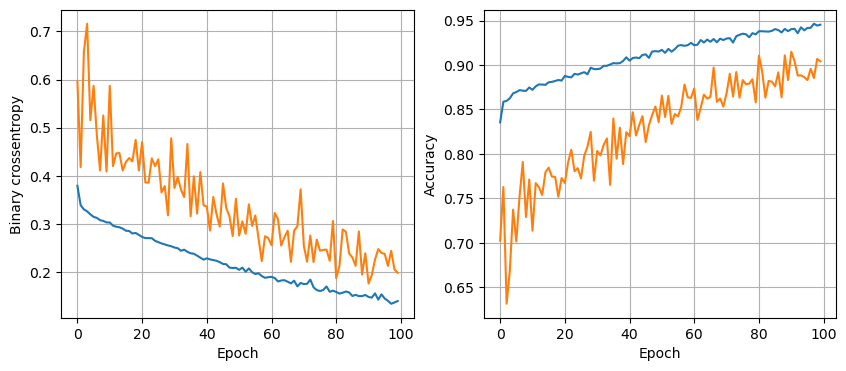

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8380 - loss: 0.6008
64 nodes, dropout 0, lr 0.005, batch size 64


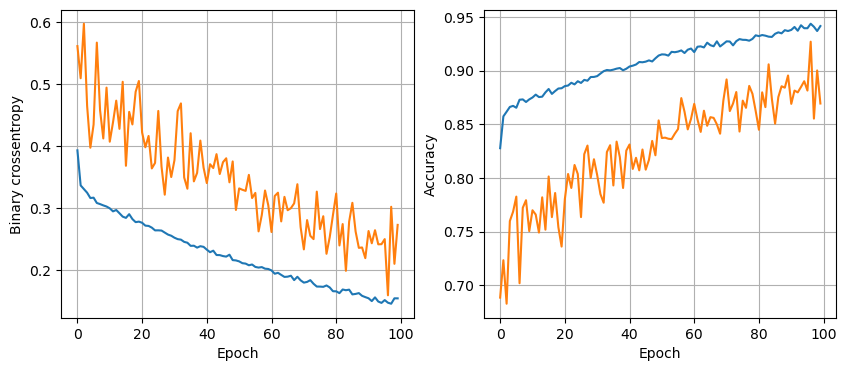

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8538 - loss: 0.4976  
64 nodes, dropout 0, lr 0.005, batch size 128


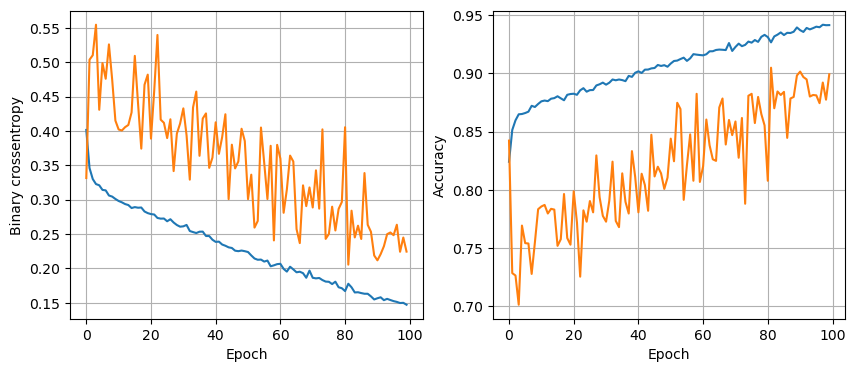

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8667 - loss: 0.4434  
64 nodes, dropout 0, lr 0.001, batch size 32


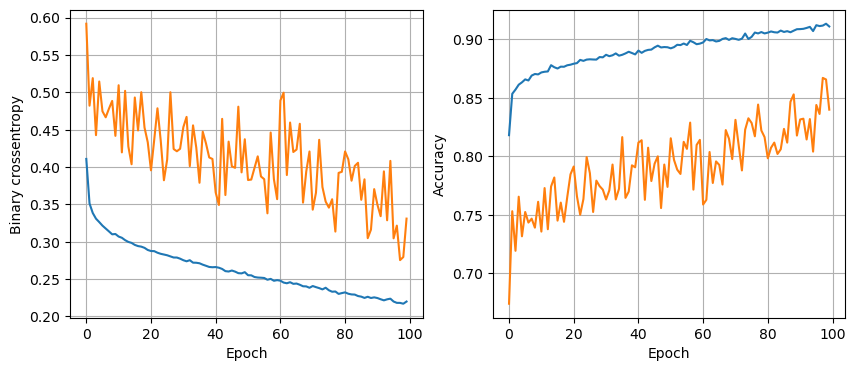

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8722 - loss: 0.3210  
64 nodes, dropout 0, lr 0.001, batch size 64


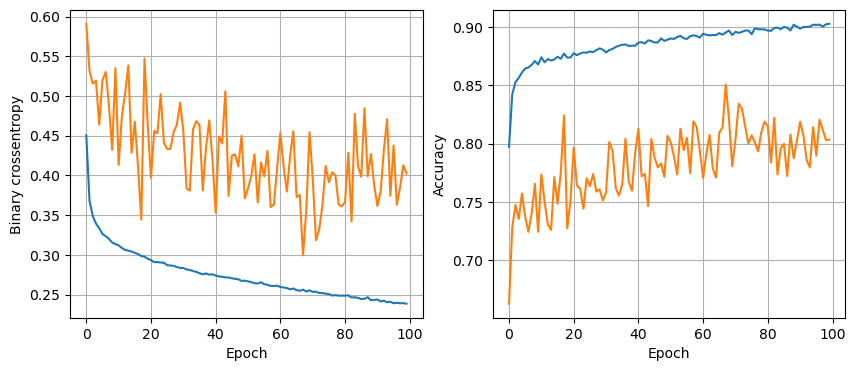

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8669 - loss: 0.3205  
64 nodes, dropout 0, lr 0.001, batch size 128


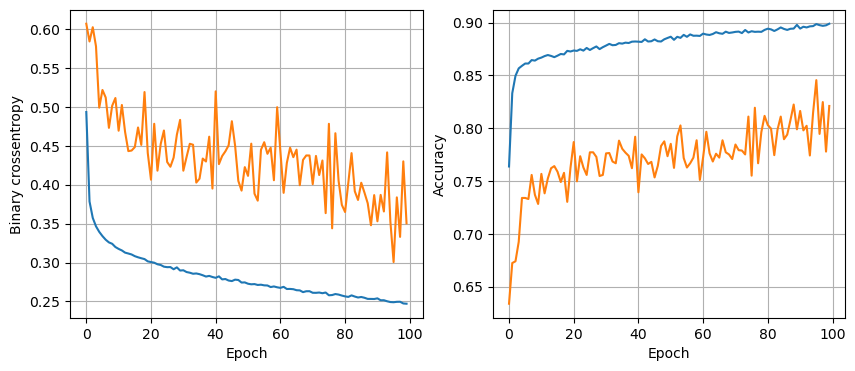

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8692 - loss: 0.3066  
64 nodes, dropout 0.2, lr 0.01, batch size 32


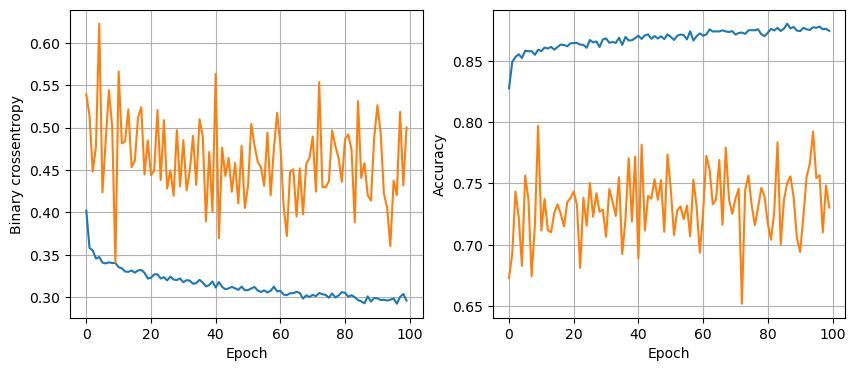

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8622 - loss: 0.3123  
64 nodes, dropout 0.2, lr 0.01, batch size 64


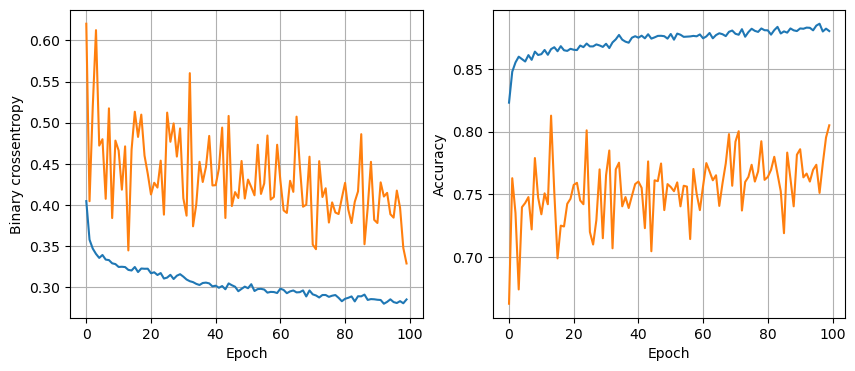

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8714 - loss: 0.2998  
64 nodes, dropout 0.2, lr 0.01, batch size 128


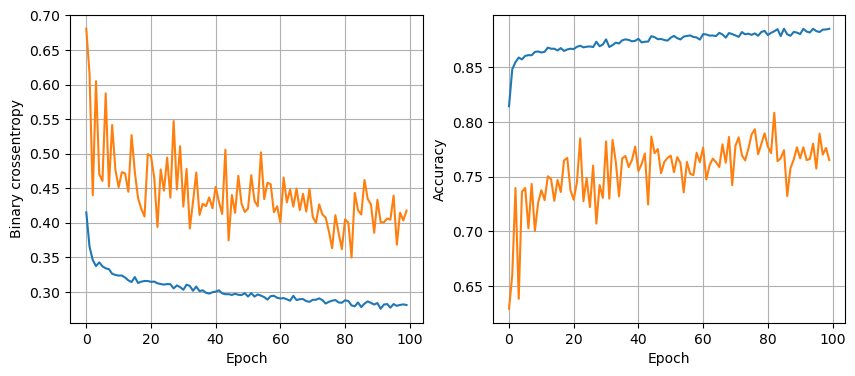

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8596 - loss: 0.3084
64 nodes, dropout 0.2, lr 0.005, batch size 32


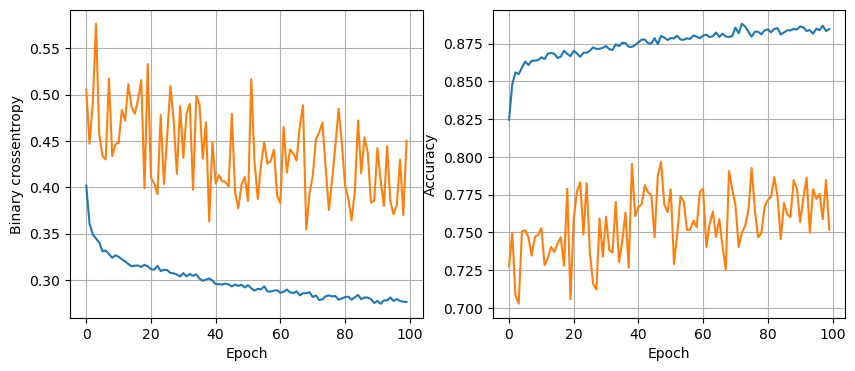

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8634 - loss: 0.3085
64 nodes, dropout 0.2, lr 0.005, batch size 64


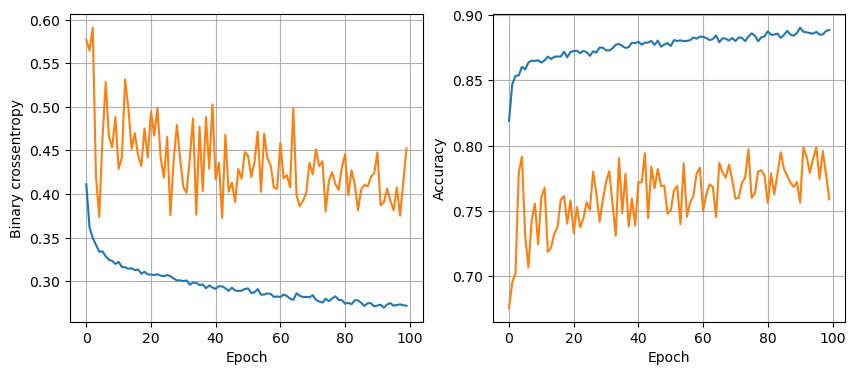

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8626 - loss: 0.3156
64 nodes, dropout 0.2, lr 0.005, batch size 128


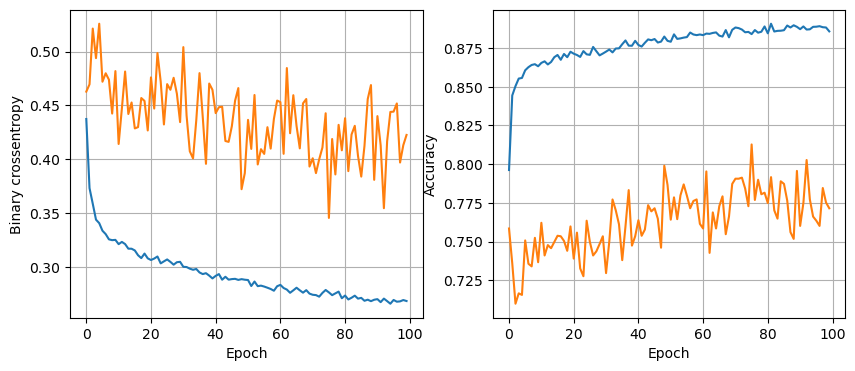

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8717 - loss: 0.3021
64 nodes, dropout 0.2, lr 0.001, batch size 32


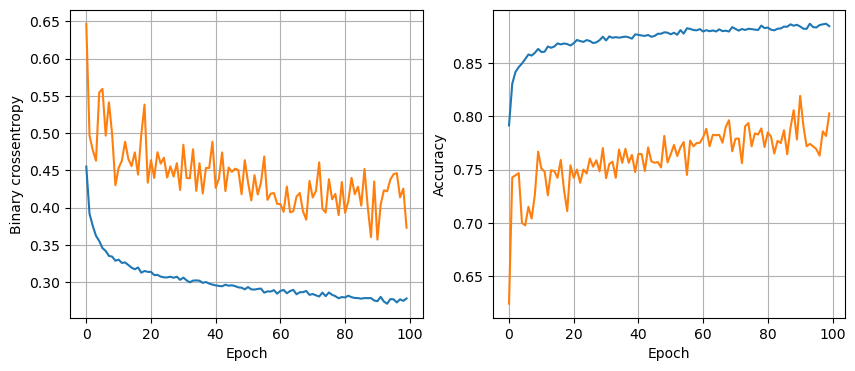

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8752 - loss: 0.2936
64 nodes, dropout 0.2, lr 0.001, batch size 64


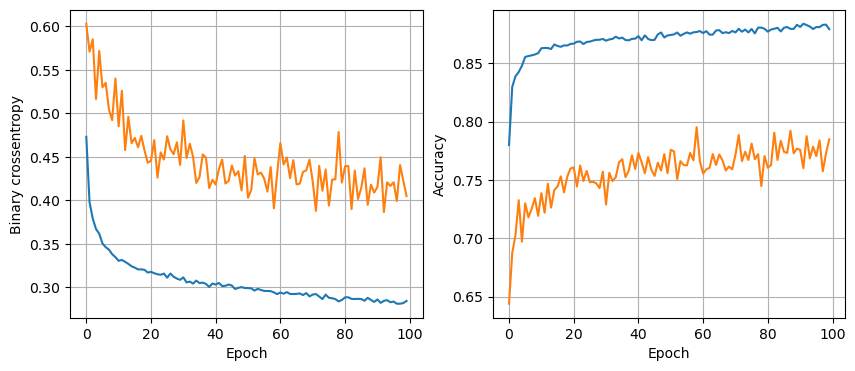

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8698 - loss: 0.2926
64 nodes, dropout 0.2, lr 0.001, batch size 128


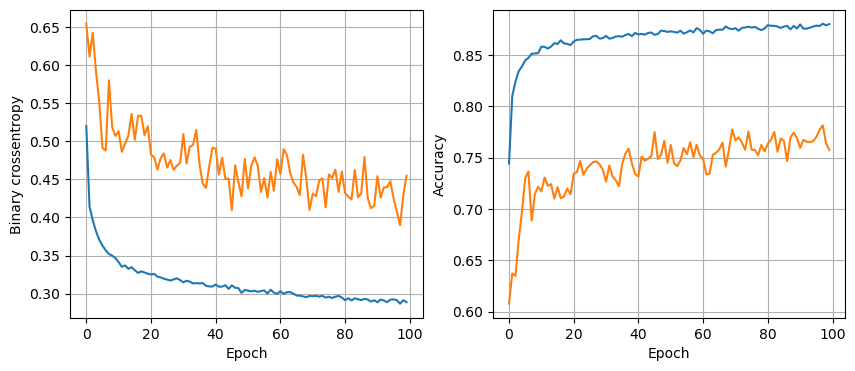

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8703 - loss: 0.2934


In [19]:
least_val_loss = float('inf')
least_loss_model = None
epochs=100
for num_nodes in [16, 32, 64]:
  for dropout_prob in[0, 0.2]:
    for lr in [0.01, 0.005, 0.001]:
      for batch_size in [32, 64, 128]:
        print(f"{num_nodes} nodes, dropout {dropout_prob}, lr {lr}, batch size {batch_size}")
        model, history = train_model(X_train, y_train, num_nodes, dropout_prob, lr, batch_size, epochs)
        plot_history(history)
        val_loss = model.evaluate(X_valid, y_valid)[0]
        if val_loss < least_val_loss:
          least_val_loss = val_loss
          least_loss_model = model

In [20]:
y_pred = least_loss_model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int).reshape(-1,)
print(classification_report(y_test, y_pred))

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
              precision    recall  f1-score   support

           0       0.90      0.73      0.80      1355
           1       0.86      0.95      0.91      2449

    accuracy                           0.87      3804
   macro avg       0.88      0.84      0.86      3804
weighted avg       0.88      0.87      0.87      3804

